In [1]:
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import pickle
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats

# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline

In [2]:
import gc
gc.collect()

15

# Funcs

In [3]:
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 

# Read data

In [4]:
# import os
# os.listdir('../ieee/input')

In [5]:
# folder_path = '../input/'
# subm = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/sample_submission.csv'))

# te_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_identity.csv'))
# te_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/test_transaction.csv'))
# tr_id = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_identity.csv'))
# tr_tr = reduce_memory_usage(pd.read_csv(f'../input/ieee-fraud-detection/train_transaction.csv'))


In [6]:
# subm = reduce_memory_usage(pd.read_csv(f'../ieee/input/sample_submission.csv'))
# te_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_identity.csv'))
# te_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/test_transaction.csv'))
# tr_id = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_identity.csv'))
# tr_tr = reduce_memory_usage(pd.read_csv(f'../ieee/input/train_transaction.csv'))

In [7]:
# files = ['../ieee/input/test_identity.csv', 
#          '../ieee/input/test_transaction.csv',
#          '../ieee/input/train_identity.csv',
#          '../ieee/input/train_transaction.csv',
#          '../ieee/input/sample_submission.csv']

In [12]:
files = ['ieee/test_identity.csv', 
         'ieee/test_transaction.csv',
         'ieee/train_identity.csv',
         'ieee/train_transaction.csv',
         'ieee/sample_submission.csv']

In [13]:
%%time
def load_data(file):
    return pd.read_csv(file)


test_id, test_tr, train_id, train_tr, sub = map(load_data, files)

Wall time: 31.4 s


In [14]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

28

In [15]:
tr_num, tr_cat = num_cat(train)
te_num, te_cat = num_cat(test)

Numerical features : 403
Categorical features : 31
Numerical features : 402
Categorical features : 31


In [16]:
import datetime
start_date = '2017-12-01' 
startdate = datetime.datetime.strptime(start_date, "%Y-%m-%d") 

for dataset in (train, test): 
    dataset["Date"] = dataset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x))) 
    dataset['Weekdays'] = dataset['Date'].dt.dayofweek 
    dataset['Hours'] = dataset['Date'].dt.hour 
    dataset['Days'] = dataset['Date'].dt.day 
    dataset['isNight'] = dataset['Hours'].map(lambda x: 1 if (x >= 23 or x < 5) else 0)

In [17]:
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [18]:
train['nulls1'] = train.isna().sum(axis=1)
test['nulls1'] = test.isna().sum(axis=1)

In [19]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [20]:
from sklearn import preprocessing
for f in train.columns:
    if  train[f].dtype=='object': 
        train[f] = train[f].replace("nan", "other")
        train[f] = train[f].replace(np.nan, "other")
        test[f] = test[f].replace("nan", "other")
        test[f] = test[f].replace(np.nan, "other")
        
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  


In [21]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [22]:
# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [ ]:
# # Some arbitrary features interaction
# for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
#                 'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

#     f1, f2 = feature.split('__')
#     train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
#     test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

#     le = LabelEncoder()
#     le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
#     train[feature] = le.transform(list(train[feature].astype(str).values))
#     test[feature] = le.transform(list(test[feature].astype(str).values))
    
    

In [23]:
for feature in ['id_34', 'id_36']:
    # Count encoded for both train and test
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        

In [24]:
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    # Count encoded separately for train and test
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [25]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [ ]:
# for f in tr_cat.columns:
#     if  tr_cat[f].dtype=='object': 
        
#         tr_cat[f] = tr_cat[f].replace("nan", "other")
#         tr_cat[f] = tr_cat[f].replace(np.nan, "other")

#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(tr_cat[f].values) )
        
#         tr_cat[f] = lbl.transform(list(tr_cat[f].values))
        
# for f in te_cat.columns:
#     if  te_cat[f].dtype=='object': 
        
#         te_cat[f] = te_cat[f].replace("nan", "other")
#         te_cat[f] = te_cat[f].replace(np.nan, "other")
        
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(te_cat[f].values) )

#         te_cat[f] = lbl.transform(list(te_cat[f].values))  


In [ ]:
# from catboost import CatBoost, Pool, cv

# cv_data = tr_cat
# labels = y
# cat_features = np.arange(tr_cat.shape[1])

# cv_dataset = Pool(data=cv_data,
#                   label=labels,
#                   cat_features=cat_features)

# params = {"iterations": 100,
#           "depth": 2,
#           "loss_function": "Logloss",
#           'custom_metric': "AUC",
#           "verbose": False}

# model = CatBoost(params)
# #train the model
# model.fit(cv_data, labels) 

# # # make the prediction using the resulting model
# # preds_class = model.predict(te_cat)
# preds_proba = model.predict_proba(te_cat)

# # scores = cv(cv_dataset,
# #             params,
# #             fold_count=2, 
# #             plot="True")

# modeling

In [34]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_jobs':3
         }

In [27]:
from time import time
import lightgbm as lgb

In [28]:
X.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True)

In [35]:
preds = np.zeros(len(test))
oof = np.zeros(len(X))

folds = KFold(n_splits=5, shuffle=False)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()


for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    1000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=200)
    
    preds += clf.predict(test)
    oof[test_idx] = clf.predict(X.iloc[test_idx])
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('OOF AUC:', roc_auc_score(y, oof))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.998695	valid_1's auc: 0.914976
[400]	training's auc: 0.999991	valid_1's auc: 0.914836
Early stopping, best iteration is:
[234]	training's auc: 0.99941	valid_1's auc: 0.915409
Fold 1 finished in 0:05:15.385007
Training on fold 2
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.999056	valid_1's auc: 0.933641
[400]	training's auc: 0.999995	valid_1's auc: 0.933182
Early stopping, best iteration is:
[231]	training's auc: 0.999569	valid_1's auc: 0.934005
Fold 2 finished in 0:04:27.015996
Training on fold 3
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.999081	valid_1's auc: 0.93186
Early stopping, best iteration is:
[192]	training's auc: 0.998876	valid_1's auc: 0.932089
Fold 3 finished in 0:04:10.296039
Training on fold 4
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.999

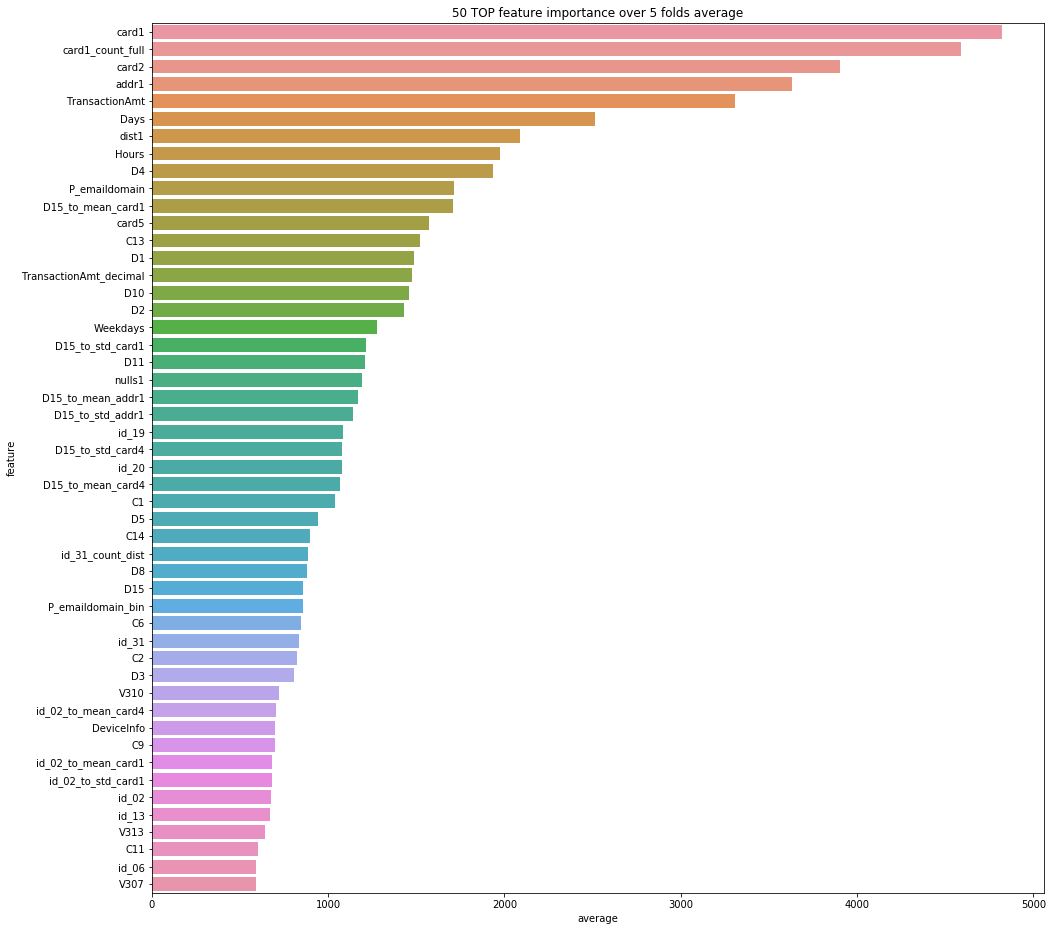

In [36]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
subm['isFraud'] = preds / folds.n_splits

In [ ]:
# subm['isFraud'] = result_dict_lgb['prediction']
# sub.to_csv('submission.csv', index=False)



all_blends =  pd.read_csv(f'../ieee/input/sample_submission.csv', index_col=0)

sub = all_blends.copy()
sub['isFraud'] =all_blends['isFraud'].values*0.6 + subm['isFraud'].values*0.4

sub.to_csv('try5.csv', float_format='%.6f')

# Features

In [ ]:
# l_num2mean = []
# for col in tr_num.columns:
#     if len(tr_num[col].value_counts()) > 1000:
#         print('-------------%s-------------' %col)
#         l_num2mean.append(col)
# #         print(tr_num[col].value_counts())

In [ ]:
# for col in l_num2mean:
#     print(col, ' ', train[col].dtype)

In [ ]:
# for item in ['TransactionID',
#  'TransactionDT', 'Date']:
#     l_num2mean.remove(item)

In [ ]:
# def nan2mean(df, col):

#     df[col] = df[col].fillna(df[col].mean())
#        #print("Mean-"+str(df[x].mean()))
#     return df

# q=0
# l = len(l_num2mean)

# for col in l_num2mean:
#     print(col)
#     q+=1
#     print('%d/%d' %(q,l))
#     train[col]=nan2mean(train, col)

# for col in l_num2mean:
#     test[col]=nan2mean(test, col)

In [ ]:
# import datetime
# START_DATE = '2017-12-01' 
# startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d") 

# for dataset in (train,test): 
#     dataset["Date"] = dataset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x))) 
#     dataset['_Weekdays'] = dataset['Date'].dt.dayofweek 
#     dataset['_Hours'] = dataset['Date'].dt.hour 
#     dataset['_Days'] = dataset['Date'].dt.day 

# train = train.drop(['TransactionDT'],axis=1) 
# test = test.drop(['TransactionDT'],axis=1)

# for item in tr_cat.columns:
#     if len(tr_cat[item].value_counts()) > 6:
#         print(item, len(tr_cat[item].value_counts()))

# le_cols = ['id_31','P_emaildomain','R_emaildomain', 'id_30', 'id_33','DeviceInfo']
# from sklearn import preprocessing

# for col in le_cols:
#     if col in train.columns:
#         le = preprocessing.LabelEncoder()
#         le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#         train[col] = le.transform(list(train[col].astype(str).values))
#         test[col] = le.transform(list(test[col].astype(str).values))   

# def yesno(df, col):
#     df[col] = df[col].map({'T':1, 'F':0})
#     return df

# def fnf(df, col):
#     df[col] = df[col].map({'Found':1, 'NotFound':0})
#     return df

# for col in ['id_37', 'id_36', 'id_35', 'id_34', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
#     train = yesno(train, col)
#     test = yesno(test, col)

# for col in ['id_27', 'id_29', 'id_16', 'id_12']:
#     train = fnf(train, col)
#     test = fnf(test, col)

# num, cat = num_cat(train)

# def onehot_encoder( df, column_name):
#     dummies = pd.get_dummies(df[column_name], prefix=""+ column_name)
#     df = df.join(dummies)
#     df = df.drop([column_name], axis=1)
#     return df

# for col in cat.columns:
#     train = onehot_encoder(train, col)
#     test = onehot_encoder(test, col)

# num, cat = num_cat(train)

# test.head()

In [ ]:
# threshold = 0.985
    
# # Absolute value correlation matrix
# corr_matrix = train[train['isFraud'].notnull()].corr().abs()

# # Getting the upper triangle of correlations
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Select columns with correlations above threshold
# to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

In [ ]:
# print('There are %d columns to remove.' % (len(to_drop)))
# train = train.drop(columns = to_drop)
# test = test.drop(columns = to_drop)

# Model

In [ ]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
# y = train.sort_values('TransactionDT')['isFraud']
# X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
# # del train
# # test = test[["TransactionDT", 'TransactionID']]

# n_fold = 5
# # folds = TimeSeriesSplit(n_splits=n_fold)

# from sklearn.model_selection import StratifiedKFold
# # folds = KFold(n_splits=5)
# folds = StratifiedKFold(n_splits=5, random_state=1)

In [ ]:
# from sklearn import metrics
# import time
# import lightgbm as lgb
# def eval_auc(y_true, y_pred):
#     """
#     Fast auc eval function for lgb.
#     """
#     return 'auc', fast_auc(y_true, y_pred), True
# metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
#                         'catboost_metric_name': 'AUC',
#                         'sklearn_scoring_function': metrics.roc_auc_score},
#                     }

In [ ]:
# def fast_auc(y_true, y_prob):
#     """
#     fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
#     """
#     y_true = np.asarray(y_true)
#     y_true = y_true[np.argsort(y_prob)]
#     nfalse = 0
#     auc = 0
#     n = len(y_true)
#     for i in range(n):
#         y_i = y_true[i]
#         nfalse += (1 - y_i)
#         auc += y_i * nfalse
#     auc /= (nfalse * (n - nfalse))
#     return auc

In [ ]:
# def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=10000, 
                               splits=None, n_folds=3, averaging='usual', n_jobs=30):
    
    
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

In [ ]:
# params = {'num_leaves': 256,
#           'min_child_samples': 79,
#           'objective': 'binary',
#           'max_depth': 13,
#           'learning_rate': 0.03,
#           "boosting_type": "gbdt",
#           "subsample_freq": 3,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'auc',
#           "verbosity": -1,
#           'reg_alpha': 0.3,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 0.9,
#           #'categorical_feature': cat_cols
#          }
# result_dict_lgb = train_model_classification(X=X_train, X_test=X_test, y=y_train, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=10000, averaging='usual', n_jobs=30)

In [ ]:
subm['isFraud'] = result_dict_lgb['prediction']
# sub.to_csv('submission.csv', index=False)



all_blends =  pd.read_csv(f'../ieee/input/sample_submission.csv', index_col=0)

sub = all_blends.copy()
sub['isFraud'] =all_blends['isFraud'].values*0.6 + subm['isFraud'].values*0.4

sub.to_csv('try4.csv', float_format='%.6f')

In [ ]:
# train.to_csv('train.csv')

In [ ]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')


In [ ]:
# params = {
#     'n_estimators': 1000,
#     'learning_rate': 0.1,
#     'num_leaves': 20,
#     'max_depth': 1,
#     'min_child_weight': 10,
#     'lambda_l1':2,
#     'lambda_l2':3,
#     'min_data_in_leaf' :10,
#     'min_sum_hessian_in_leaf' : 0.0001,
#     'bagging_fraction' : 0.8,
#     'max_bin': 12,
#     'feature_fraction' : 0.9,
#     'bagging_freq' : 100,
#     'min_gain_to_split': 0.1 }

In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import TimeSeriesSplit
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin

# def objective(params):

#     print("############## New Run ################")
#     print("PARAMETERS: ")
#     print(f"params  = {params}")
    
#     params = {
#     'n_estimators': int(params['n_estimators']),
#     'learning_rate': params['learning_rate'],
#     'num_leaves': int(params['num_leaves']),
#     'max_depth': 1,
#     'min_child_weight': int(params['min_child_weight']),
#     'lambda_l1':params['lambda_l1'],
#     'lambda_l2':params['lambda_l2'],
#     'min_data_in_leaf' :int(params['min_data_in_leaf']),
#     'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'],
#     'bagging_fraction' : params['bagging_fraction'],
#     'max_bin': int(params['max_bin']),
#     'feature_fraction' : params['feature_fraction'],
#     'bagging_freq' : int(params['bagging_freq']),
#     'min_gain_to_split': params['min_gain_to_split']
#     }
    
#     EPOCHS = 3
#     tss = TimeSeriesSplit(n_splits=EPOCHS)
#     score_mean = 0
#     print("CV SCORE: ")
#     for tr_idx, val_idx in tss.split(X_train, y_train):
#         clf = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'],
#                 learning_rate=params['learning_rate'],
#                 num_leaves=params['num_leaves'],
#                 max_depth=params['max_depth'],
#                 min_child_weight=params['min_child_weight'],
#                 lambda_l1=params['lambda_l1'],
#                 lambda_l2=params['lambda_l2'],
#                 min_data_in_leaf=params['min_data_in_leaf'],
#                 min_sum_hessian_in_leaf=params['min_sum_hessian_in_leaf'],
#                 bagging_fraction=params['bagging_fraction'],
#                 max_bin=params['max_bin'],
#                 feature_fraction=params['feature_fraction'],
#                 bagging_freq=params['bagging_freq'],
#                 min_gain_to_split=params['min_gain_to_split'])

#         X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
#         y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
#         clf.fit(X_tr, y_tr)
        
#         y_pred_train = clf.predict_proba(X_vl)[:,1]
#         score = roc_auc_score(y_vl, y_pred_train)
#         score_mean += score
#         print(f'ROC AUC {score}')
        
#     del X_tr, X_vl, y_tr, y_vl, clf, y_pred_train    
#     gc.collect()
#     print(f'Mean ROC_AUC: {score_mean / EPOCHS} \n')
#     return -(score_mean / EPOCHS)


# space = {
#     'n_estimators': hp.quniform('n_estimators', 900, 910, 1),
#     'num_leaves': hp.quniform('num_leaves', 5, 600, 1),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 700, 1),
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
#     'max_bin': hp.quniform('max_bin', 5, 500, 1),
#     'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 500, 1), 
#     'lambda_l1': hp.uniform('lambda_l1', 0, 3), 
#     'lambda_l2': hp.uniform('lambda_l2', 0, 3),
# #     'min_data_in_leaf' :hp.quniform('min_data_in_leaf', 5, 50, 1),
#     'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0, 0.01),
#     'bagging_fraction' : hp.uniform('bagging_fraction', 0, 0.9),
#     'max_bin': hp.quniform('max_bin', 10, 500, 1),
#     'feature_fraction' : hp.uniform('feature_fraction', 0, 0.9),
#     'bagging_freq' : hp.quniform('bagging_freq', 10, 1000, 10),
#     'min_gain_to_split': hp.uniform('min_gain_to_split', 0.1, 1),     
# }


In [ ]:
# # Set algoritm parameters
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100)

In [ ]:
# best['num_leaves'] = int(best['num_leaves'])
# best['bagging_freq'] = int(best['bagging_freq'])
# best['max_bin'] = int(best['max_bin'])
# best['min_child_weight'] = int(best['min_child_weight'])
# best['min_data_in_leaf'] = int(best['min_data_in_leaf'])
# best['n_estimators'] = int(best['n_estimators'])

In [ ]:
# best = {
#     'n_estimators': 5000,
#     'bagging_fraction': 0.1,
#  'colsample_bytree': 0.6,
#  'feature_fraction': 0.788941629218398,
#  'max_depth': 30,
#  'min_child_samples': 100,
#  'min_child_weight': 1.004827043917695e-05,
#  'min_data_in_leaf': 20,
#  'num_leaves': 250,
#  'reg_alpha': 1.6158062156738595,
#  'reg_lambda': 1.0000000104049402,
#  'subsample': 0.7999999740778657}


In [ ]:
# lgb = lightgbm.LGBMClassifier(**best)
# lgb.fit(X_train, y_train, eval_metric='auc') 

# y_preds = lgb.predict_proba(X_test)[:,1]

In [ ]:
# sample_submission_anya = pd.read_csv(f'../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
# sample_submission_anya['isFraud'] = y_preds


In [ ]:
# all_blends =  pd.read_csv(f'../input/ensemble-on-fire/submission.csv', index_col=0)

# # sub_path = "../input/Ensemble on fire/ensemble"
# # all_files = os.listdir(sub_path)

# # all_blends = pd.read_csv(os.path.join(sub_path, 'submission.csv'), index_col=0)

# sub = all_blends.copy()
# # sub.head()

# sub['isFraud'] =all_blends['isFraud'].values*0.6 + sample_submission_anya['isFraud'].values*0.4

# sub.to_csv('try3.csv', float_format='%.6f')

In [ ]:
# sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

In [ ]:
# sample_submission['isFraud'] = y_preds
# sample_submission.to_csv('try1.csv')